In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing, model_selection
import csv
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import random

### Data Preparation

In [2]:
def get_dataset(directory, lag, excluded_name=[]):
    data = pd.DataFrame(columns=['data', 'label'])
    for foldername in os.listdir(directory):        
        folder = os.path.join(directory, foldername)
        # print(folder)
        if str(lag) in folder:
            # print(os.listdir(folder))
            for name in os.listdir(folder):
                if name in excluded_name:
                    # print(name)
                    continue
                filename = os.path.join(folder, name)
                # print(filename)
                for files in os.listdir(filename):
                    rel_path = os.path.join(filename, files)
                    # print(rel_path)
                    temp_label = folder
                    if "autism" in temp_label:
                        label = 'autism'
                    else:
                        label = 'normal'

                    temp_data = pd.DataFrame(columns=['data', 'label'], index=[0])

                    rwb = np.load(rel_path)
                    rwb.astype(np.float64).reshape(-1,1)
                                    
                    temp_data.loc[0, "data"] = rwb
                    temp_data['label'] = label
                    data = pd.concat([data, temp_data], ignore_index=True)
    label_map = {"autism": 1, "normal": 0}
    data['label_map'] = data['label'].map(label_map)      
    return data

In [3]:
def remove_missing_value(data):
    series_list = np.vstack(data["data"].values)
    labels_list = data["label_map"].values    
    missing_indices = np.where(np.isnan(series_list).any(axis=1))[0]

    clean_data = data.drop(index=data.index[missing_indices])
    return clean_data

In [4]:
def save_dataset(data, des_path):
    if not os.path.exists(des_path):
        os.makedirs(des_path)
    data.save(des_path)

In [5]:
def get_train_test(data, train_split: float):
    train_x, test_x, train_y, test_y = model_selection.train_test_split(
        data['data'],
        data[['label', 'label_map']],
        train_size=train_split,
        stratify=data['label_map']
    )

    train_df = pd.DataFrame(columns=['data', 'label', 'label_map'])
    test_df = pd.DataFrame(columns=['data', 'label', 'label_map'])

    train_df["data"] = train_x
    train_df[['label', 'label_map']] = train_y

    test_df["data"] = test_x
    test_df[['label', 'label_map']] = test_y

    return train_df, test_df

In [6]:
def get_batch(data):
    # loading extracted feature & label
    # x = get_dataset(path, lag, excluded_name)

    # scaler = preprocessing.MinMaxScaler()

    series_list = np.vstack(data["data"].values)

    # series_list = series_list.reshape(-1, 366, 1)

    labels_list = data["label_map"].values
        
    # y = keras.utils.to_categorical(y[0])
    dataset = tf.data.Dataset.from_tensor_slices((series_list,labels_list))
    dataset = dataset.shuffle(len(labels_list))

    # train_size = int(train_split * len(labels_list))  
    # test_size = len(labels_list) - train_size  

    # train_dataset = dataset.take(train_size)
    # test_dataset = dataset.skip(train_size)

    BATCH_SIZE = 32

    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [7]:
data_dir = "datasets/features/rwb/segment_1 seconds"

train_dir = "datasets/tf_batch/rwb/segment_1 seconds/train"
test_dir = "datasets/tf_batch/rwb/segment_1 seconds/test"

In [8]:
excluded = ["zyad"]
train_split = 0.8
LAG = [256]

for lag in LAG:
    data = get_dataset(data_dir, lag, excluded)
    print(data.shape)
    data = remove_missing_value(data)
    print(data.shape)
    train_data, test_data = get_train_test(data, train_split)
    print("train: ", train_data.shape)
    print("test: ", test_data.shape)
    train_batch = get_batch(train_data)
    test_batch = get_batch(test_data)
    tf.data.Dataset.save(train_batch, f"{train_dir}_{lag}")
    tf.data.Dataset.save(test_batch, f"{test_dir}_{lag}")

(15434, 3)
(14618, 3)
train:  (11694, 3)
test:  (2924, 3)


### Exploratory Data Analysis

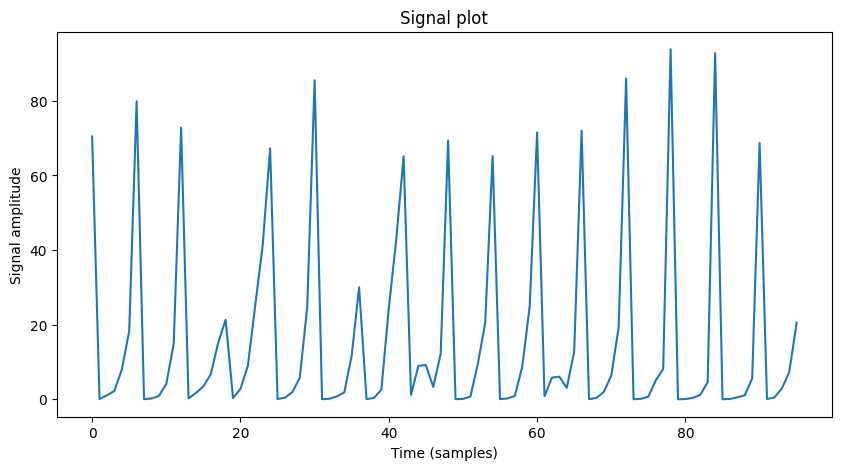

In [12]:
# Load the CSV file into a DataFrame
signal = np.load("datasets/features/rwb/segment_1 seconds/normal_256/amer/Amer_segment_1.csv_bispectrum.npy")

# Extract the signal values from the DataFrame

# Create a time axis for the signal
t = range(len(signal))

fig, ax = plt.subplots(figsize=(10, 5))
# Plot the signal
ax.plot(t, signal)
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Signal amplitude')
ax.set_title('Signal plot')
plt.show()

### Model Definition

In [8]:
def create_model():
    model = keras.models.Sequential()

    model.add(layers.Input(shape=(96,)))
    model.add(layers.Reshape((96, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

### Define Callbacks

In [9]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='acc',
    patience=50,
    mode='max')
    model_path = os.path.join(log_dir,'best_model.h5')
    mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    return [tensorboard_callback, early_stopping, mc]
    

### Main Program

In [10]:
lags = [256]
# folds = ['train_1', 'test_1', 'epoch_1', 'train_2', 'test_2', 'epoch_2']
time_measured = ['Wall_Time_1', 'CPU_Time_1', 'Wall_Time_2', 'CPU_Time_2']
epochs = 2000
log_dirs = [f"train_logs/logs7/RWB_ANN_512_256_256_512_Adam"]

In [11]:
for log_dir in log_dirs:
    recap = pd.DataFrame(index=lags, columns=range(1, 6))
    training_time = pd.DataFrame(index=lags, columns=[f'CPU_Time_{i}' for i in range(1, 6)] + [f'Wall_Time_{i}' for i in range(1, 6)])

    for lag in lags:
        train_temp_dir = train_dir + '_' + str(lag)
        train = tf.data.Dataset.load(train_temp_dir)
        flattened_train = train.unbatch()

        train_data = list(flattened_train.as_numpy_iterator())
        train_size = len(list(train_data))

        kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

        for fold, (train_index, val_index) in enumerate(kf.split(train_data), 1):
            train_fold_data = ([train_data[i][0] for i in train_index], [train_data[i][1] for i in train_index])
            val_fold_data = ([train_data[i][0] for i in val_index], [train_data[i][1] for i in val_index])

            train_fold = tf.data.Dataset.from_tensor_slices(train_fold_data).batch(32)
            val_fold = tf.data.Dataset.from_tensor_slices(val_fold_data).batch(32)

            log_path = os.path.join(log_dir, str(fold), str(lag))

            model = create_model()
            model.summary()

            model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['acc'])

            cpu_start = time.process_time()
            wt_start = time.time()

            history = model.fit(train_fold, epochs=epochs, validation_data=val_fold, callbacks=myCallbacks(log_path))

            wt_end = time.time()
            cpu_end = time.process_time()
            wall_time = wt_end - wt_start
            cpu_time = cpu_end - cpu_start

            training_time.loc[lag, f'CPU_Time_{fold}'] = cpu_time
            training_time.loc[lag, f'Wall_Time_{fold}'] = wall_time

            recap.loc[lag, fold] = history.history['acc'][-1]


    # Evaluate on the test dataset after cross-validation
    test_temp_dir = test_dir + '_' + str(lag)
    test_ds = tf.data.Dataset.load(test_temp_dir)
    results = model.evaluate(test_ds, callbacks=myCallbacks(log_path))

    recap[f'test_{lag}'] = results[1]

    log_recap_dir = os.path.join(log_dir, 'Recap')
    if not os.path.exists(log_recap_dir):
        os.makedirs(log_recap_dir)

    recap.to_csv(os.path.join(log_recap_dir, 'recap.csv'))
    training_time.to_csv(os.path.join(log_recap_dir, 'Training_time.csv'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 1)             0         
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 512)               49664     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               6

In [12]:
# Load Best Model
LAG = 256

test_dir = f"datasets/tf_batch/RWB/segment_1 seconds/test_{LAG}"
test_ds = tf.data.Dataset.load(test_dir)
model_dir = [f"train_logs/logs7/RWB_ANN_512_256_256_512_Adam/{i}/{LAG}/best_model.h5" for i in range(1,6)]

In [13]:
flattened_test = test_ds.unbatch()
test_data = list(flattened_test.as_numpy_iterator())

In [14]:
test_data_value = np.array([test_data[i][0] for i in range(len(test_data))])
test_data_label = np.array([test_data[i][1] for i in range(len(test_data))])

In [15]:
test_data_value.reshape(test_data_value.shape[0], -1).shape

(2924, 96)

In [16]:
results = []

for i, model_path in enumerate(model_dir):
    model = keras.models.load_model(model_path)
    loss, acc = model.evaluate(test_ds)
    print(loss, acc)
    pred = model.predict(test_data_value.reshape(test_data_value.shape[0], -1))
    results.append(pred)

92/92 [==============================] - 0s 1ms/step - loss: 0.4348 - acc: 0.7972
0.4348430037498474 0.7971956133842468
92/92 [==============================] - 0s 1ms/step - loss: 0.4380 - acc: 0.8006
0.4379970133304596 0.8006156086921692
92/92 [==============================] - 0s 1ms/step - loss: 0.4525 - acc: 0.8044
0.4524590075016022 0.804377555847168
92/92 [==============================] - 0s 2ms/step - loss: 0.4352 - acc: 0.7934
0.4351736903190613 0.793433666229248
92/92 [==============================] - 0s 2ms/step - loss: 0.4300 - acc: 0.7986
0.42995381355285645 0.7985635995864868
92/92 [==============================] - 0s 2ms/step


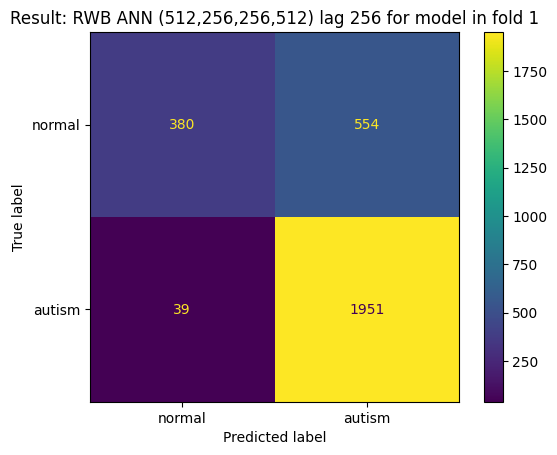

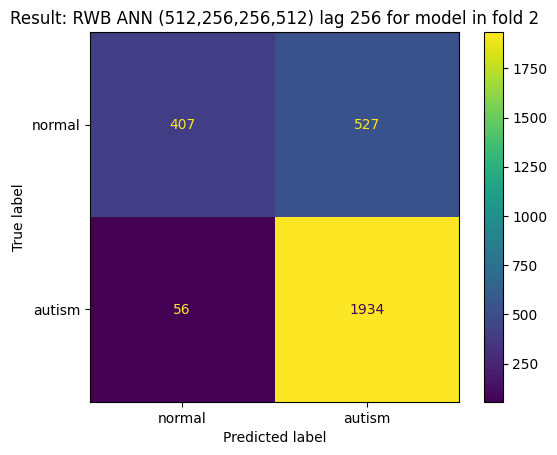

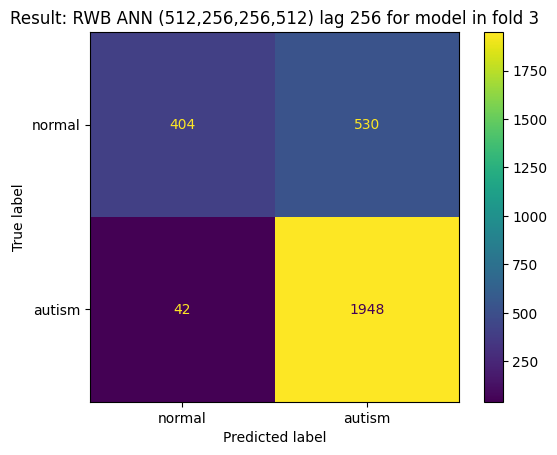

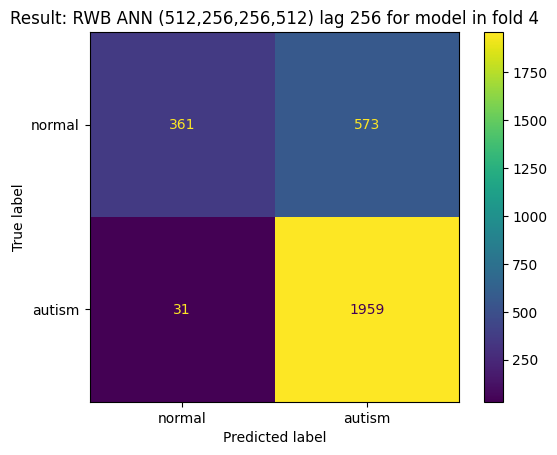

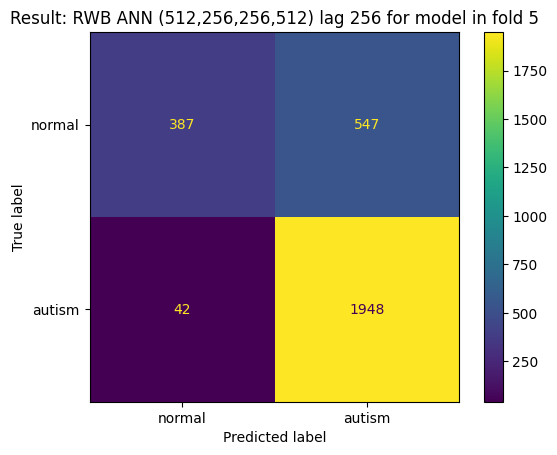

In [18]:
from sklearn import metrics

for i, res in enumerate(results, 1):
    pred = np.round(res.reshape(res.shape[0])).astype(bool)
    confusion_matrix = metrics.confusion_matrix(test_data_label.astype(bool), pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'autism'])
    cm_display.plot()
    plt.title(f"Result: RWB ANN (512,256,256,512) lag 256 for model in fold {i}")
    plt.show()

In [19]:
for i, res in enumerate(results, 1):
    pred = np.round(res.reshape(res.shape[0])).astype(bool)
    test_data_label = test_data_label.astype(bool)  

    print(f"Result: RWB ANN (512,256,256,512)(Adam) lag 256 for model in fold {i}")

    TP = np.sum((test_data_label == True) & (pred == True))
    FP = np.sum((test_data_label == False) & (pred == True))
    TN = np.sum((test_data_label == False) & (pred == False))
    FN = np.sum((test_data_label == True) & (pred == False))  

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {f1_score}")
    print("\n")

Result: RWB ANN (512,256,256,512)(Adam) lag 256 for model in fold 1
Precision: 0.7788423153692615
Recall: 0.9804020100502513
Accuracy: 0.7971956224350205
F1-score: 0.868075639599555


Result: RWB ANN (512,256,256,512)(Adam) lag 256 for model in fold 2
Precision: 0.7858594067452255
Recall: 0.9718592964824121
Accuracy: 0.8006155950752394
F1-score: 0.8690181981577173


Result: RWB ANN (512,256,256,512)(Adam) lag 256 for model in fold 3
Precision: 0.7861178369652946
Recall: 0.978894472361809
Accuracy: 0.8043775649794802
F1-score: 0.8719785138764549


Result: RWB ANN (512,256,256,512)(Adam) lag 256 for model in fold 4
Precision: 0.773696682464455
Recall: 0.9844221105527639
Accuracy: 0.7934336525307798
F1-score: 0.8664307828394515


Result: RWB ANN (512,256,256,512)(Adam) lag 256 for model in fold 5
Precision: 0.7807615230460921
Recall: 0.978894472361809
Accuracy: 0.7985636114911081
F1-score: 0.8686733556298774


